In [19]:
from matplotlib import cm, colors, pyplot as plt
import metaworld
import torch
from torch import nn
import copy
import ray
import numpy as np
import seaborn as sns

from nupic.embodied.utils.garage_utils import create_policy_net
from nupic.embodied.multitask.samplers.gpu_sampler import SamplerEvalOnly
from nupic.embodied.multitask.hooks.sparse_viz import (
    AverageSegmentActivationsHook,
    HiddenActivationsPercentOnHook,
    CombinedSparseVizHook
)

from garage.experiment.task_sampler import MetaWorldTaskSampler

from nupic.embodied.utils.parser_utils import merge_args
sys.path.append("/Users/lsouza/nta/nupic.embodied/projects/multitask")
from args_parser import create_exp_parser
from experiments import CONFIGS

import numpy
import torch

from scipy.spatial.distance import cosine
from collections import Counter, defaultdict

# MLP-Dendrites Comparison

In [44]:
class HiddenActivationsPercentOnHookMLP(HiddenActivationsPercentOnHook):
    def attach(self, network):
        network.module.mean_log_std._layers[1].register_forward_hook(self.activation_hook_fn)     

def get_updated_policy(policy, hook):
    with torch.no_grad():
        updated_policy = copy.deepcopy(policy)
    updated_policy.eval()
    hook(updated_policy)
    return updated_policy

def init_experiment(state_path, config, mlp=False, average_hook=False):
    mt_env = metaworld.MT10(seed=41)
    train_task_sampler = MetaWorldTaskSampler(
        mt_env, "train", add_env_onehot=True
    )
    mt_train_envs = train_task_sampler.sample(10)
    env = mt_train_envs[0]()

    exp_parser = create_exp_parser()
    trainer_args = merge_args(exp_parser.parse_dict(CONFIGS[config]))

    env = mt_train_envs[0]()
    policy = create_policy_net(env_spec=env.spec, net_params=trainer_args)

    if state_path is not None:
        experiment_state = torch.load(state_path, map_location=torch.device('cpu'))
        policy.load_state_dict(experiment_state["algorithm"]["policy"])

    if mlp:
        print("Using MLP network")
        hook = HiddenActivationsPercentOnHookMLP
    elif average_hook:
        hook =AverageSegmentActivationsHook
    else:
        hook = HiddenActivationsPercentOnHook

    net = get_updated_policy(policy, hook)

    sampler = SamplerEvalOnly(
        agent=net,
        envs=mt_train_envs,
        max_episode_length=env.spec.max_episode_length,
        cpus_per_worker=0.5,
        gpus_per_worker=0,
        workers_per_env=1,
        seed=42,
    )

    return net, sampler

def collect_data(net, sampler, num_eval_eps=1):

    samples, hook_data = sampler.obtain_exact_episodes(
        n_eps_per_worker=num_eval_eps,
        agent_update=net,
        collect_hook_data=True,
    )

    data = next(iter(hook_data.values()))

    return samples, data

def get_distances(data):
    distances = np.zeros((10,10))
    for i in range(len(data)):
        for j in range(len(data)):
            average_acts_i = data[i].mean(dim=0)
            average_acts_j = data[j].mean(dim=0)
            distances[i][j] = cosine(average_acts_i, average_acts_j)

    return distances

def calculate_avg_distances(data, num_samples=40):
    distances_same_task = []
    distances_other_task = []
    for i in range(len(data)):
        for j in range(len(data)):
            if i == j:
                distances_per_type = distances_same_task
            else:
                distances_per_type = distances_other_task
            acts_i = data[i]
            acts_j = data[j]
            for x in range(num_samples):# range(acts_i.shape[0]):
                for y in range(num_samples): # range (acts_j.shape[0]):
                    distances_per_type.append(cosine(acts_i[x, :], acts_j[y, :]))
    print("\nDistance same task: {:.4f}, across tasks: {:.4f}\n".format(
        np.mean(distances_same_task), np.mean(distances_other_task)
    ))          

def report(state_path, config, mlp=False, num_samples=100, average_hook=False):
    net, sampler = init_experiment(state_path, config, mlp=mlp, average_hook=average_hook)
    data = collect_data(net, sampler)
    distances = get_distances(data)
    calculate_avg_distances(data, num_samples=num_samples)
    sns.heatmap(distances)
    return net, sampler, data, distances

def get_network(state_path, config, mlp=False, num_samples=100, average_hook=False):
    net, sampler = init_experiment(state_path, config, mlp=mlp, average_hook=average_hook)
    return net, sampler




## Comparisons


Distance same task: 0.4117, across tasks: 0.8861



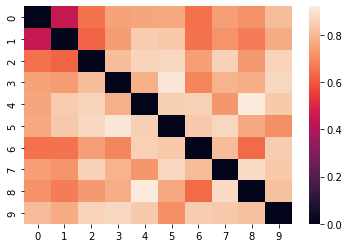

In [21]:
state_path = "/Users/lsouza/nta/results/no_preprocess3-wouv839/experiment_state.p"
config = "no_preprocess6"
report(state_path, config, mlp=False);

Using MLP network

Distance same task: 0.4253, across tasks: 0.8937



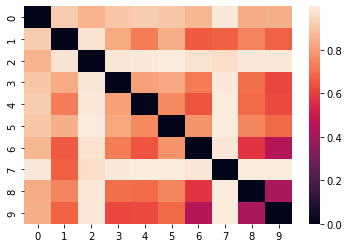

In [22]:
state_path_mlp = "/Users/lsouza/nta/results/mlp_final-dtbi450/experiment_state.p"
config_mlp = "mlp_final"
report(state_path_mlp, config_mlp, mlp=True);

Using MLP network

Distance same task: 0.0668, across tasks: 0.9314



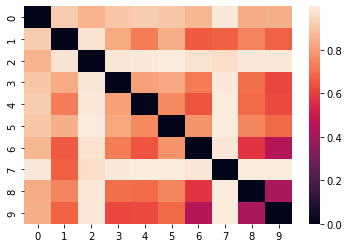

In [24]:
def report(state_path, config, mlp=False, num_samples=100, average_hook=False):
    net, sampler = init_experiment(state_path, config, mlp=mlp, average_hook=average_hook)
    data = collect_data(net, sampler)
    distances = get_distances(data)
    calculate_avg_distances(data, num_samples=num_samples)
    sns.heatmap(distances)
    return net, sampler, data, distances

net, sampler, data, distances = report(state_path_mlp, config_mlp, num_samples=10, mlp=True)

In [45]:
state_path = "/Users/lsouza/nta/results/no_preprocess3-wouv839/experiment_state.p"
config = "no_preprocess6"
net, sampler = init_experiment(state_path, config)
samples, data = collect_data(net, sampler, num_eval_eps=3)

/Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/garage/experiment/deterministic.py:36: UserWarning: Enabeling deterministic mode in PyTorch can have a performance impact when using GPU.
  warnings.warn(


In [46]:
for task_id in range(10):
    print(len(data[task_id]))

1500
1500
1500
1500
1500
1500
1500
1500
1500
1500


In [122]:
from collections import Counter, defaultdict
task_ids = {}
task_aggs = {}

# dictionary: task -> list of samples. 
for task_id in range(10):
    task_ids[task_id] = torch.zeros(data[0][0].shape)
    task_aggs[task_id] = torch.zeros(data[0][0].shape)
    num_samples = len(task_ids[task_id])
    for sample_tensor in data[task_id]:
        task_ids[task_id] += sample_tensor > 0
    
    # task_aggs[task_id] = task_ids[task_id] > num_samples * .50

    _, argmax_indices = torch.topk(task_ids[task_id], k=int(num_samples/4))
    task_aggs[task_id][argmax_indices] = 1    


In [124]:
task_aggs[0]

tensor([0., 0., 0.,  ..., 1., 0., 0.])

In [ ]:
# _, argmax_indices = torch.topk(task_ids[task_id])
# task_aggs[task_id][argmax_indices] = 1

In [125]:
for task_id in range(10):
    print(task_aggs[task_id].sum())

tensor(700.)
tensor(700.)
tensor(700.)
tensor(700.)
tensor(700.)
tensor(700.)
tensor(700.)
tensor(700.)
tensor(700.)
tensor(700.)


In [126]:
distances = np.zeros((10,10))
for taskA in range(10):
    for taskB in range(10):
        distances[taskA][taskB] = (task_aggs[taskA] * task_aggs[taskB]).sum()

<AxesSubplot:>

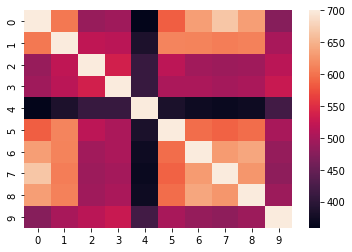

In [127]:
sns.heatmap(distances)

In [105]:
tasks_ordered = []
for task in range(0,15000,1500):
    tasks_ordered.append(samples.env_infos["task_name"][task])
tasks_ordered

['reach-v2',
 'push-v2',
 'pick-place-v2',
 'door-open-v2',
 'drawer-open-v2',
 'drawer-close-v2',
 'button-press-topdown-v2',
 'peg-insert-side-v2',
 'window-open-v2',
 'window-close-v2']

In [35]:
task_ids[0][0] += 1

In [36]:
task_ids

defaultdict(collections.Counter, {0: Counter({0: 1})})

In [129]:
from collections import Counter, defaultdict

def calculate_distance_overlap(task_aggs):
    distances = np.zeros((10,10))
    for taskA in range(10):
        for taskB in range(10):
            distances[taskA][taskB] = (task_aggs[taskA] * task_aggs[taskB]).sum()
    return distances

def aggregate_representations(data, agg_by_kwinner=True):
    task_ids = {}
    task_aggs = {}

    # dictionary: task -> list of samples. 
    for task_id in range(10):
        task_ids[task_id] = torch.zeros(data[0][0].shape)
        num_samples = len(task_ids[task_id])
        for sample_tensor in data[task_id]:
            task_ids[task_id] += sample_tensor > 0

        if agg_by_kwinner:
            task_aggs[task_id] = torch.zeros(data[0][0].shape)       
            _, argmax_indices = torch.topk(task_ids[task_id], k=int(num_samples/4))
            task_aggs[task_id][argmax_indices] = 1    
        else:
            task_aggs[task_id] = task_ids[task_id] > num_samples * .50

    return task_aggs


/Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/garage/experiment/deterministic.py:36: UserWarning: Enabeling deterministic mode in PyTorch can have a performance impact when using GPU.
  warnings.warn(


<AxesSubplot:>

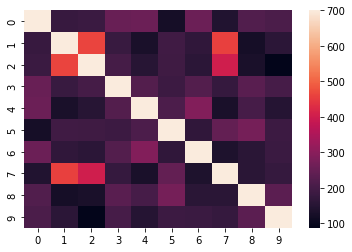

In [130]:
state_path = "/Users/lsouza/nta/results/no_preprocess3-wouv839/experiment_state.p"
config = "no_preprocess6"
net, sampler = init_experiment(state_path, config, mlp=False)
samples, data = collect_data(net, sampler, num_eval_eps=3)

task_aggs = aggregate_representations(data)
distances = calculate_distance_overlap(task_aggs)
sns.heatmap(distances)

/Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/garage/experiment/deterministic.py:36: UserWarning: Enabeling deterministic mode in PyTorch can have a performance impact when using GPU.
  warnings.warn(


<AxesSubplot:>

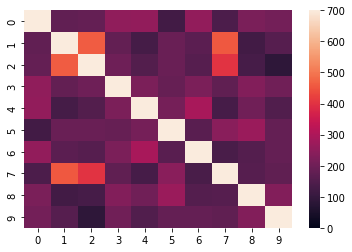

In [134]:
state_path = "/Users/lsouza/nta/results/no_preprocess3-wouv839/experiment_state.p"
config = "no_preprocess6"
net, sampler = init_experiment(state_path, config, mlp=False)
samples, data = collect_data(net, sampler, num_eval_eps=3)

task_aggs = aggregate_representations(data)
distances = calculate_distance_overlap(task_aggs)
sns.heatmap(distances, vmin=0, vmax=700)

Using MLP network


<AxesSubplot:>

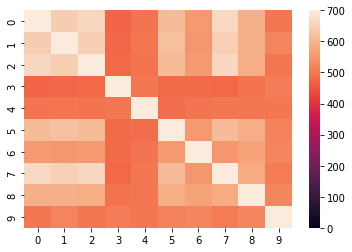

In [135]:
state_path = "/Users/lsouza/nta/results/mlp_final-dtbi450/experiment_state.p"
config = "mlp_final"
net, sampler = init_experiment(state_path, config, mlp=True)
samples, data = collect_data(net, sampler, num_eval_eps=3)

task_aggs = aggregate_representations(data)
distances = calculate_distance_overlap(task_aggs)
sns.heatmap(distances, vmin=0, vmax=700)

In [ ]:
# run pairwise
